# Hidden Markov Model for Regime Detection

This notebook implements a Gaussian Hidden Markov Model (HMM) to identify market regimes (bull and bear markets) using weekly SPY and GLD data.

In [5]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from hmmlearn.hmm import GMMHMM
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Download data 

In [6]:
import yfinance as yf
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Define the tickers and date range
start_date = '2000-01-01'  # Start from when GLD was launched
end_date = '2024-12-31'    # Adjust as needed

# Download SPY data
print("Downloading SPY data...")
spy_data = yf.download('SPY', start=start_date, end=end_date, progress=False)
spy_data.reset_index().to_csv('data/spy_data.csv', index=False) 
spy_data.to_csv('data/spy_data.csv')
print(f"SPY data saved to data/spy_data.csv - Shape: {spy_data.shape}")

# Download GLD data
print("Downloading GLD data...")
gld_data = yf.download('GLD', start=start_date, end=end_date, progress=False)
gld_data.reset_index().to_csv('data/gld_data.csv', index=False)
gld_data.to_csv('data/gld_data.csv')
print(f"GLD data saved to data/gld_data.csv - Shape: {gld_data.shape}")

SPY data saved to data/spy_data.csv - Shape: (6288, 5)
SPY data saved to data/spy_data.csv - Shape: (6288, 5)
GLD data saved to data/gld_data.csv - Shape: (5062, 5)
GLD data saved to data/gld_data.csv - Shape: (5062, 5)


# Load and Preprocess Data

In [7]:
import pandas as pd
import numpy as np

# === 1. Load & clean SPY ===
spy = pd.read_csv("data/spy_data.csv", header=[0, 1], index_col=0)
spy.columns = spy.columns.get_level_values(0)   # flatten multi-index
spy.index = pd.to_datetime(spy.index)

# === 2. Load & clean GLD ===
gld = pd.read_csv("data/gld_data.csv", header=[0, 1], index_col=0)
gld.columns = gld.columns.get_level_values(0)
gld.index = pd.to_datetime(gld.index)

# === 3. Weekly resample (Friday close) ===
spy_weekly = spy['Close'].resample('W-FRI').last()
gld_weekly = gld['Close'].resample('W-FRI').last()

# === 4. Compute log returns ===
spy_returns = np.log(spy_weekly / spy_weekly.shift(1)).dropna().to_frame(name='SPY_Returns')
gld_returns = np.log(gld_weekly / gld_weekly.shift(1)).dropna().to_frame(name='GLD_Returns')

# === 5. Merge returns ===
df_returns = spy_returns.join(gld_returns, how='inner')


print(df_returns.head())

            SPY_Returns  GLD_Returns
Date                                
2004-11-26     0.007889     0.011325
2004-12-03     0.007576     0.006821
2004-12-10     0.000671    -0.048527
2004-12-17     0.005634     0.017118
2004-12-24     0.011074     0.001809


# Base Strategy - Gauss HMM

In [107]:
#Define the parameters and the HMM model
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
strategy_returns_GaussHMM = []

#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #
    train_data_raw = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data_raw[['SPY_Returns']])

    model = GaussianHMM(n_components=2, covariance_type='diag', n_iter=100, random_state=1806)
    model.fit(train_data)

    #Transition probability
    posteriors = model.predict_proba(train_data)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data)
    train_data_raw = train_data_raw.copy()
    train_data_raw['State'] = states

    state_returns = train_data_raw.groupby('State')['SPY_Returns'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY_Returns']
    r_gld = df_returns.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GaussHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

In [108]:
strategy_df_gauss = pd.DataFrame(strategy_returns_GaussHMM, columns=['Date', 'Strategy_Return_GaussHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_gauss.set_index( 'Date', inplace=True)
strategy_df_gauss['Cumulative_Strategy_GaussHMM'] = (1+strategy_df_gauss['Strategy_Return_GaussHMM']).cumprod()
strategy_df_gauss['Cumulative_SPY']= (1 + strategy_df_gauss ['SPY_Return']).cumprod()
strategy_df_gauss['Cumulative_GLD']= (1 + strategy_df_gauss ['GLD_Return']).cumprod()
strategy_df_gauss

,Strategy_Return_GaussHMM,SPY_Return,GLD_Return,GLD_Weight,Cumulative_Strategy_GaussHMM,Cumulative_SPY,Cumulative_GLD
Date,,,,,,,
2006-11-24,0.011336,-0.000499,0.027460,0.419869,1.011336,0.999501,1.027460
2006-12-01,0.004300,-0.000926,0.009716,0.489735,1.015684,0.998575,1.037444
2006-12-08,-0.006860,0.008522,-0.032816,0.376946,1.008716,1.007085,1.003399
2006-12-15,-0.003480,0.012040,-0.017067,0.536823,1.005206,1.019210,0.986274
2006-12-22,0.000815,-0.011233,0.010599,0.549121,1.006025,1.007761,0.996728
...,...,...,...,...,...,...,...
2024-11-29,-0.005150,0.011752,-0.017157,0.588161,4.157158,4.409196,3.084409
2024-12-06,0.000404,0.008692,-0.010808,0.427402,4.158837,4.447519,3.051074
2024-12-13,-0.001353,-0.005940,0.005500,0.399579,4.153209,4.421099,3.067856


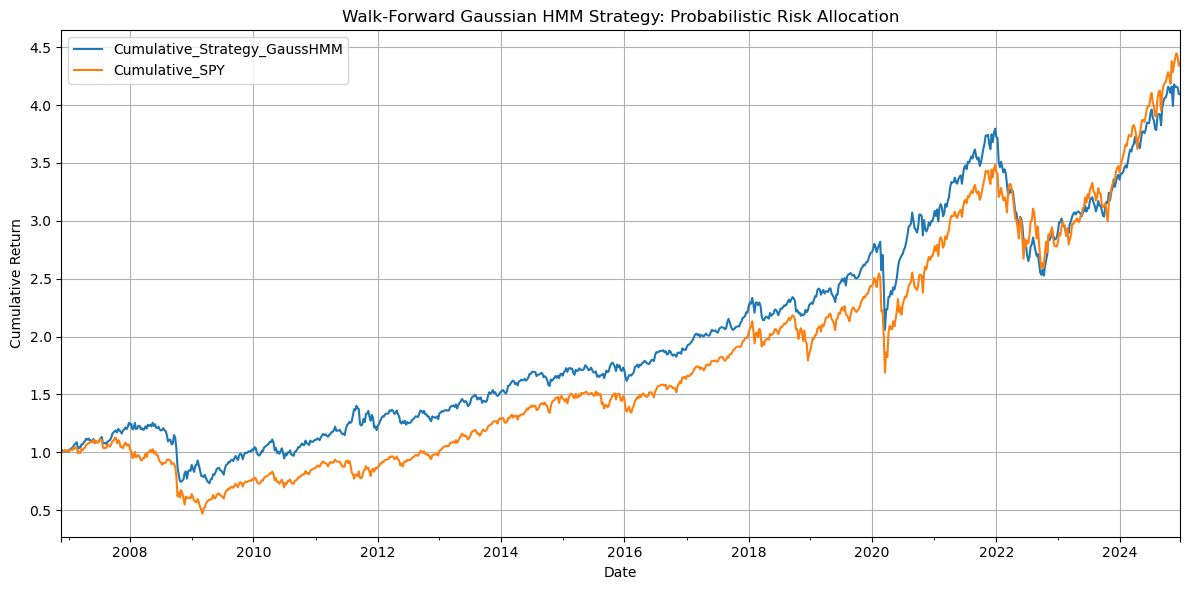

In [109]:
strategy_df_gauss[['Cumulative_Strategy_GaussHMM', 'Cumulative_SPY']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
def compute_stats(returns, freq='W'):
    periods_per_year = {'D': 252, 'W': 52, 'M': 12}[freq]

    #CAGR
    cumulative_return = (1 + returns).prod()
    n_periods = len(returns)
    years = n_periods / periods_per_year
    cagr = cumulative_return ** (1 / years) - 1

    #Max and average drawdown
    rolling = (1 + returns).cumprod()
    peak = rolling.cummax()
    drawdown = (rolling - peak) / peak
    max_dd = drawdown.min()
    avg_dd = drawdown[drawdown < 0].mean()

    # Sharpe Ratio
    volatility = returns.std() * np.sqrt(periods_per_year)  #for simplicity risk free rate is 0
    sharpe = returns.mean() / returns.std() * np.sqrt(periods_per_year) # it is still a good metric to compare risk and return between different models

    return {
        'CAGR': cagr,
        'Max Drawdown': max_dd,
        'Average Drawdown': avg_dd,
        'Sharpe Ratio': sharpe
    }

In [111]:
stats_strategy_gauss = compute_stats(strategy_df_gauss['Strategy_Return_GaussHMM'], freq='W')
stats_spy = compute_stats(strategy_df_gauss['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_gauss['GLD_Return'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gauss, stats_spy],
    index=['GaussHMM strategy', 'SPY']
)
print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GaussHMM strategy  0.0806       -0.4170           -0.0914        0.5921
SPY                0.0845       -0.5836           -0.1289        0.5343


Strategia sembra funzionare bene, CAGR simile drawdown molto ridotto. ma confrontiamola con una strategia di base molto semplice, ovvero 50/50

#################COMMENTO

The GaussHMM strategy shows slightly lower CAGR (8.06%) compared to SPY (8.45%), indicating a modest underperformance in absolute return. However, it significantly outperforms SPY in terms of risk-adjusted returns and drawdowns:

Max Drawdown is substantially lower in the GaussHMM strategy (-41.7% vs. -58.4%), implying better capital preservation during market downturns.

Average Drawdown is also less severe (-9.14% vs. -12.89%), further supporting the strategy’s ability to mitigate losses.

Sharpe Ratio is higher for GaussHMM (0.5921 vs. 0.5343), indicating superior risk-adjusted performance.

Conclusion: While the GaussHMM strategy slightly lags SPY in CAGR, it provides a more stable return profile with lower drawdowns and improved risk-adjusted returns, making it potentially more attractive for risk-averse investors.

################

In [112]:
strategy_df_gauss['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_gauss['SPY_Return']) + 0.5 * np.exp(strategy_df_gauss['GLD_Return']) )
strategy_df_gauss['Cumulative_Mixed'] = (1+strategy_df_gauss['Mixed_Returns']).cumprod()

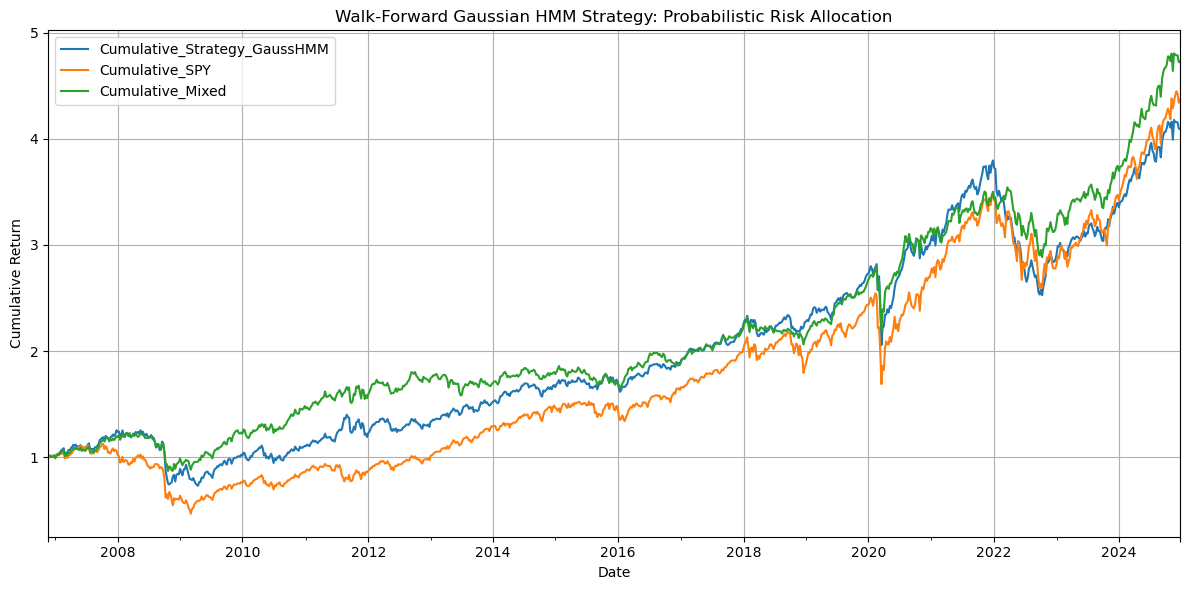

In [113]:
strategy_df_gauss[['Cumulative_Strategy_GaussHMM', 'Cumulative_SPY','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
stats_mixed = compute_stats(strategy_df_gauss['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gauss, stats_spy, stats_gld, stats_mixed],
    index=['GaussHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GaussHMM strategy  0.0806       -0.4170           -0.0914        0.5921
SPY                0.0845       -0.5836           -0.1289        0.5343
GLD                0.0629       -0.4805           -0.2244        0.4498
50/50              0.0893       -0.2924           -0.0482        0.7304


Non abbiamo battuto portafoglio benchmark 50/50, proviamo ad apportare modifiche al modello.

########## COMMENTO
While the GaussHMM strategy offers a decent compromise between return and risk, the simple 50/50 allocation between SPY and GLD surprisingly delivers the best overall profile, especially for conservative investors seeking lower volatility and better Sharpe performance.
########## 

Modifichiamo l'assumption dei gaussian returns, proviamo a utilizzare una gaussian mixture. solitamente si usano da 2 a 4 gaussiane.


# GMM HMM Strategy

In [11]:
#Define the parameters and the HMM model
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
n_mix = 3 #number of Gaussian
strategy_returns_GMMHMM = []

#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #Select only data from the window selected
    train_data = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    # scaler = StandardScaler()
    # train_data = scaler.fit_transform(train_data[['SPY_Returns']])

    model = GMMHMM(n_components=n_components, n_mix = n_mix, covariance_type='tied', n_iter=100, random_state=1806)
    model.fit(train_data[['SPY_Returns']].values)

    #Transition probability
    posteriors = model.predict_proba(train_data[['SPY_Returns']].values)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data[['SPY_Returns']].values)
    train_data = train_data.copy()
    train_data['State'] = states

    state_returns = train_data.groupby('State')['SPY_Returns'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY_Returns']
    r_gld = df_returns.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GMMHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

In [12]:
strategy_df_gmm = pd.DataFrame(strategy_returns_GMMHMM, columns=[ 'Date', 'Strategy_Return_GMMHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_gmm.set_index( 'Date', inplace=True)
strategy_df_gmm['Cumulative_Strategy_GMMHMM'] = (1+strategy_df_gmm['Strategy_Return_GMMHMM']).cumprod()
strategy_df_gmm['Cumulative_SPY'] = (1 + strategy_df_gmm ['SPY_Return']).cumprod()
strategy_df_gmm['Cumulative_GLD'] = (1 + strategy_df_gmm ['GLD_Return']).cumprod()
strategy_df_gmm['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_gmm['SPY_Return']) + 0.5 * np.exp(strategy_df_gmm['GLD_Return']) )
strategy_df_gmm['Cumulative_Mixed'] = (1+strategy_df_gmm['Mixed_Returns']).cumprod()

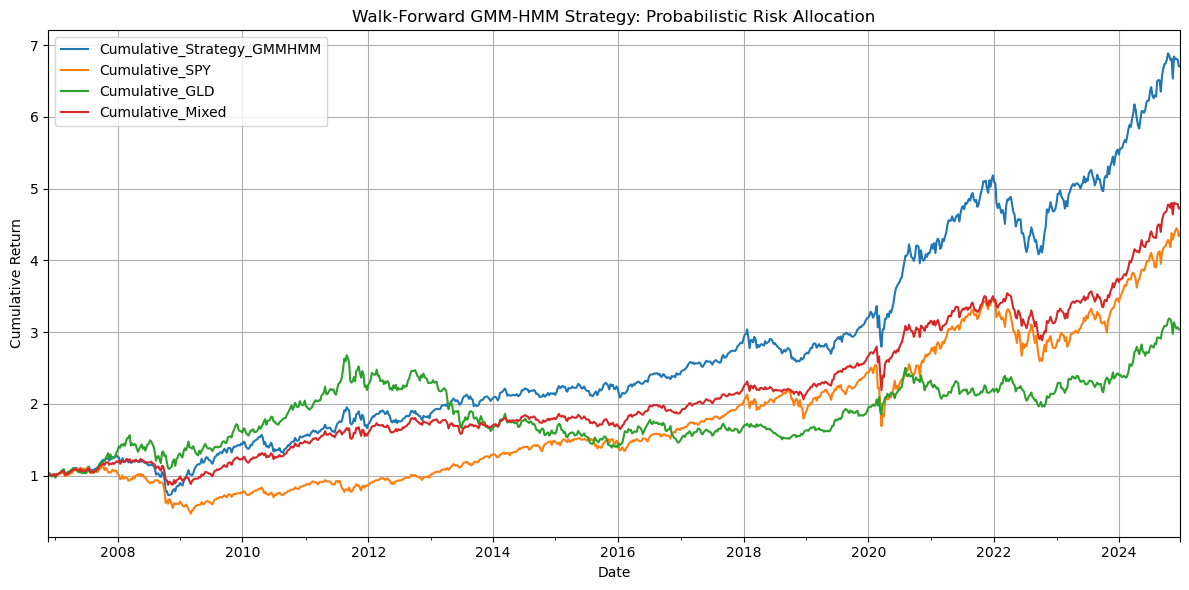

In [13]:
strategy_df_gmm[['Cumulative_Strategy_GMMHMM', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward GMM-HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
stats_strategy_gmm = compute_stats(strategy_df_gmm['Strategy_Return_GMMHMM'], freq='W')
stats_spy = compute_stats(strategy_df_gmm['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_gmm['GLD_Return'],freq='W' )
stats_mixed = compute_stats(strategy_df_gmm['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gmm, stats_spy, stats_gld, stats_mixed],
    index=['GMMHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                   CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GMMHMM strategy  0.1104       -0.4332           -0.0602        0.7896
SPY              0.0845       -0.5836           -0.1289        0.5343
GLD              0.0629       -0.4805           -0.2244        0.4498
50/50            0.0893       -0.2924           -0.0482        0.7304


The GMMHMM strategy offers the best overall performance, combining high returns with strong risk-adjusted metrics. It successfully balances return and risk better than all the static benchmarks. The 50/50 portfolio, while more conservative, remains a robust alternative with the best drawdown profile.

The GMMHMM strategy is beating our 50/50 benchmark. However the 50/50 strategy is much safer, lower drawdown. Let's try to use the GMMHMM model in a bivariate way.  We expect the market and the volatility to be negatively correlated

# Bivariate GMM HMM

In [119]:
#Compute Volatility - create a copy to avoid modifying original data
df_returns_biv = df_returns.copy()
df_returns_biv['Volatility'] = df_returns_biv['SPY_Returns'].rolling(window=4).std()
df_returns_biv.dropna(inplace=True)

In [120]:
#Define the parameters and the HMM model
window_size_biv = 104   # 208 weeks
n_components_biv = 2    #The two states are the two regimes
n_mix_biv = 3 #number of Gaussian
strategy_returns_GMMHMM_biv = []
exception_count = 0

#Walk forward loop
for i in range(window_size_biv, len(df_returns_biv)-1):

    #Select only data from the window selected
    train_data = df_returns_biv.iloc[i - window_size_biv:i]
    test_index = df_returns_biv.index[i]

    X_train = train_data[['SPY_Returns','Volatility']].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    #print("DEBUG: X_train_scaled shape:", X_train_scaled.shape)
    #print("DEBUG: X_train_scaled std:", np.std(X_train_scaled, axis=0))

    try:
        model = GMMHMM(n_components = n_components_biv, n_mix = n_mix_biv, covariance_type='diag', n_iter=100, random_state=1806)
        model.fit(X_train_scaled)

        #Transition probability
        posteriors = model.predict_proba(X_train_scaled)
        pi_t = posteriors[-1]   #Vector with the probablity of being in each state
        pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

        #Predict states
        states = model.predict(X_train)  
        train_data=train_data.copy()
        train_data['State'] = states

        state_returns = train_data.groupby('State')['SPY_Returns'].mean()
        high_risk_state = state_returns.idxmin()

        #Asset allocation
        weight_gld = pi_next[high_risk_state]
        weight_spy = 1 - weight_gld
    except:
        weight_gld = 0.5
        weight_spy = 0.5
        exception_count += 1

    r_spy = df_returns_biv.loc[test_index, 'SPY_Returns']
    r_gld = df_returns_biv.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GMMHMM_biv.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

In [121]:
strategy_df_biv = pd.DataFrame(strategy_returns_GMMHMM_biv, columns=[ 'Date', 'Strategy_Return_GMMHMM_biv', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_biv.set_index( 'Date', inplace=True)
strategy_df_biv['Cumulative_Strategy_GMMHMM_biv'] = (1+strategy_df_biv['Strategy_Return_GMMHMM_biv']).cumprod()
strategy_df_biv['Cumulative_SPY'] = (1 + strategy_df_biv['SPY_Return']).cumprod()
strategy_df_biv['Cumulative_GLD'] = (1 + strategy_df_biv['GLD_Return']).cumprod()
strategy_df_biv['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_biv['SPY_Return']) + 0.5 * np.exp(strategy_df_biv['GLD_Return']) )
strategy_df_biv['Cumulative_Mixed'] = (1+strategy_df_biv['Mixed_Returns']).cumprod()

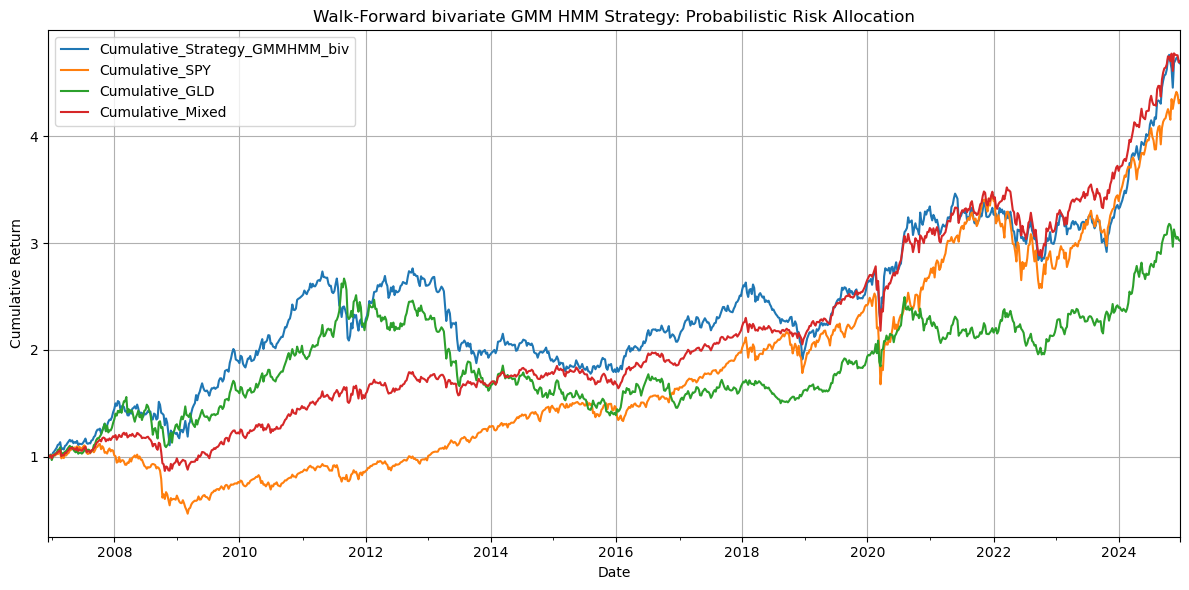

In [122]:
strategy_df_biv[['Cumulative_Strategy_GMMHMM_biv', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward bivariate GMM HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
stats_strategy_biv = compute_stats(strategy_df_biv['Strategy_Return_GMMHMM_biv'], freq='W')
stats_spy = compute_stats(strategy_df_biv['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_biv['GLD_Return'],freq='W' )
stats_mixed = compute_stats(strategy_df_biv['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_biv, stats_spy, stats_gld, stats_mixed],
    index=['Biv GMMHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                       CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
Biv GMMHMM strategy  0.0890       -0.3570           -0.1309        0.6207
SPY                  0.0844       -0.5836           -0.1290        0.5331
GLD                  0.0629       -0.4805           -0.2257        0.4499
50/50                0.0892       -0.2924           -0.0483        0.7294


Adding a the variance informations does not improve the model performance. Let's stick to the univariate model.

We can still conclude that we beat our benchmark. Hurray! However, our 50/50 strategy benchmark is not completely correct. We have to include the dividends. Let's switch then the current SPY data with the S&P500 total returns. We can use these data as an accurate enought proxy for the total returns of the spy. AGGIUNGI POI IL RESTO

# Dividend adjusted benchmark

In [ ]:
import yfinance as yf
import pandas as pd

# Scarico S&P 500 Total Return
sp500tr = yf.download("^SP500TR", start="2000-01-01", end="2024-12-31")
sp500tr.to_csv("data/sp500_total_return.csv")   #proxy dello spy total return (INDAGA E CAPISCI MEGLIO)

/var/folders/6x/hxz75_4j6m11pg3y6mqt4ny40000gn/T/ipykernel_62194/1127747590.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500tr = yf.download("^SP500TR", start="2000-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open   Volume
Ticker         ^SP500TR     ^SP500TR     ^SP500TR     ^SP500TR ^SP500TR
Date                                                                   
2000-01-03  2002.109985  2002.109985  2002.109985  2002.109985        0
2000-01-04  1925.410034  1925.410034  1925.410034  1925.410034        0
2000-01-05  1929.280029  1929.280029  1929.280029  1929.280029        0
2000-01-06  1931.510010  1931.510010  1931.510010  1931.510010        0
2000-01-07  1983.829956  1983.829956  1983.829956  1983.829956        0


In [ ]:
spy_tr = pd.read_csv("data/sp500_total_return.csv", header=[0, 1], index_col=0)
spy_tr.columns = spy_tr.columns.get_level_values(0)   # flatten multi-index
spy_tr.index = pd.to_datetime(spy_tr.index)

spy_tr_weekly = spy_tr['Close'].resample('W-FRI').last()

spy_tr_returns = np.log(spy_tr_weekly / spy_tr_weekly.shift(1)).dropna().to_frame(name='SPY_TR_Returns')

df_returns = df_returns.join(spy_tr_returns, how='left')

print(df_returns.head())

            SPY_Returns  GLD_Returns  SPY_TR_Returns
Date                                                
2004-11-26     0.007889     0.011325        0.010690
2004-12-03     0.007576     0.006821        0.007694
2004-12-10     0.000671    -0.048527       -0.002335
2004-12-17     0.005634     0.017118        0.005477
2004-12-24     0.011074     0.001809        0.013619


In [16]:
strategy_df_gmm['SPY_TR_Returns'] = df_returns['SPY_TR_Returns']
strategy_df_gmm['Cumulative_SPY_TR'] = (1+strategy_df_gmm['SPY_TR_Returns']).cumprod()

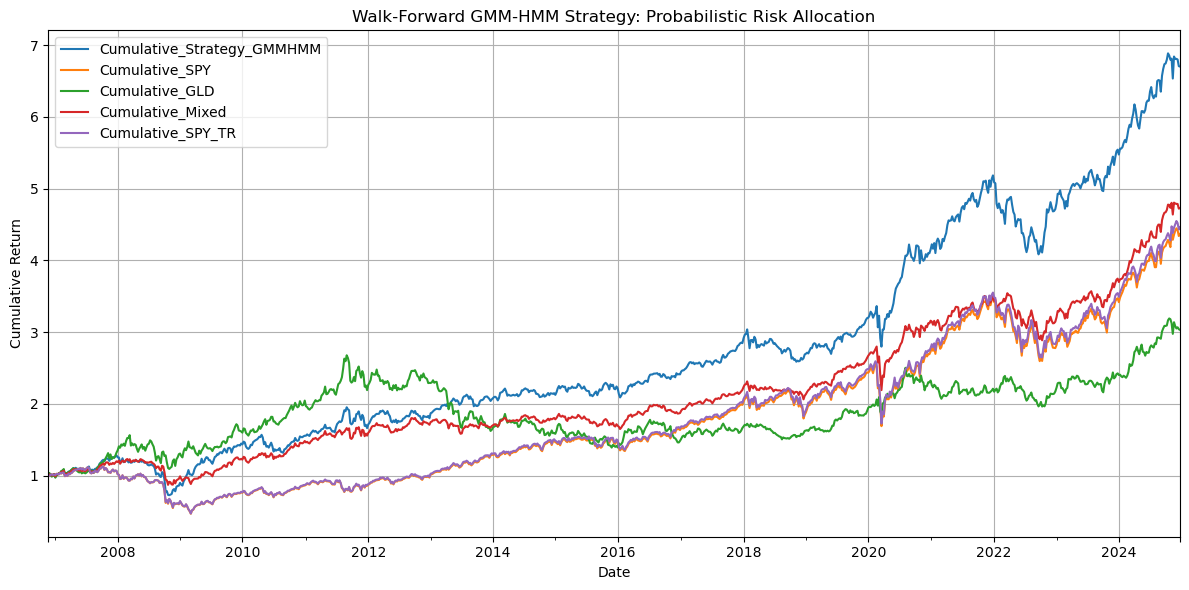

In [18]:
strategy_df_gmm[['Cumulative_Strategy_GMMHMM', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed','Cumulative_SPY_TR']].plot(figsize=(12, 6))
plt.title("Walk-Forward GMM-HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
stats_spy_tr = compute_stats(strategy_df_gmm['SPY_TR_Returns'], freq='W')

report = pd.DataFrame(
    [stats_strategy_gmm, stats_spy, stats_gld, stats_mixed, stats_spy_tr],
    index=['GMMHMM strategy', 'SPY', 'GLD','50/50', 'SPY Total Returns']
)

print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GMMHMM strategy    0.1104       -0.4332           -0.0602        0.7896
SPY                0.0845       -0.5836           -0.1289        0.5343
GLD                0.0629       -0.4805           -0.2244        0.4498
50/50              0.0893       -0.2924           -0.0482        0.7304
SPY Total Returns  0.0858       -0.5816           -0.1269        0.5435


HURRAY! Our strategy performs much better than the markets even when adjusting for dividends. We're one step closer to Jim Simons.

RIFAI TUTTO CON SPY TR ANCHE LA MIXED STRATEGY.